    This notebook aims to discuss the FPN paper and some other related staff. The text mostly copied from or othe rrelevant resources.

## Object Detection frameworks recap 

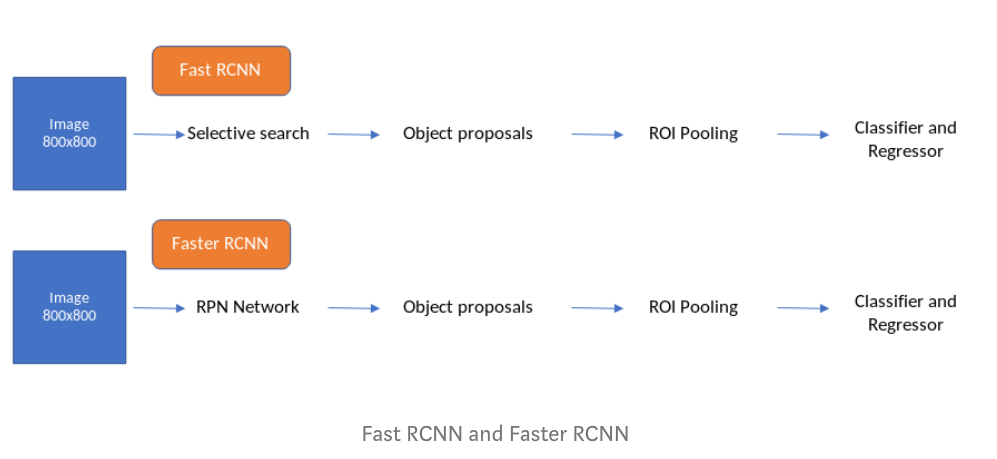

Let’s take a quick look at the Fast R-CNN and Faster R-CNN data flow below. It works with one feature map layer to create ROIs. We use the ROIs and the feature map layer to create feature patches to be fed into the ROI pooling.

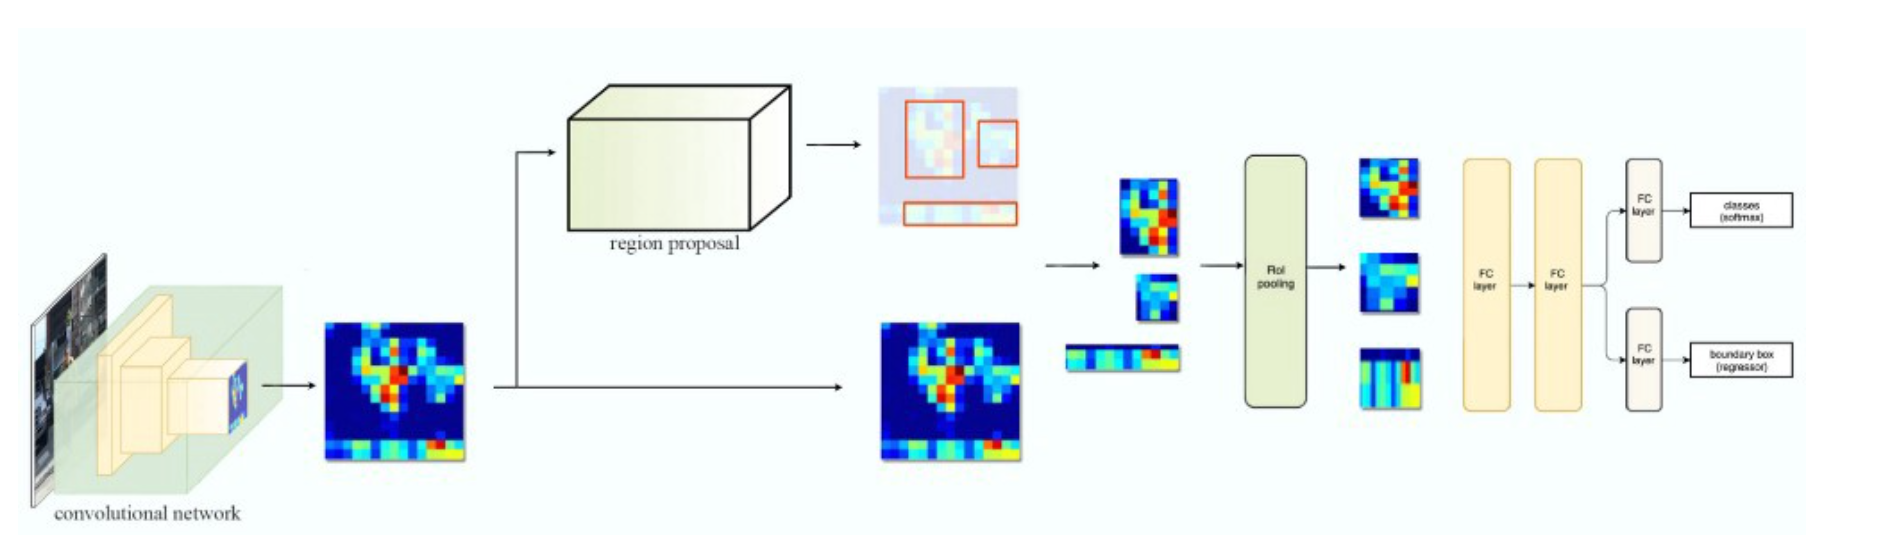

The only difference you can observe in the above diagram is that Faster RCNN has replaced the **[selective search](https://www.learnopencv.com/selective-search-for-object-detection-cpp-python/)** with ***RPN (Region proposal network) network***. The selective search algorithm uses SIFT and HOG descriptors to generate object proposals and it takes 2 sec per image on CPU. This is a costly process and Fast RCNN takes 2.3 seconds in total to generate predictions on one image, where as Faster RCNN works at 5 FPS (frames per second) even when using very deep image classifiers like VGGnet (ResNet and ResNext are also used now) in the back-end.

Total Number of Region Proposals: 621


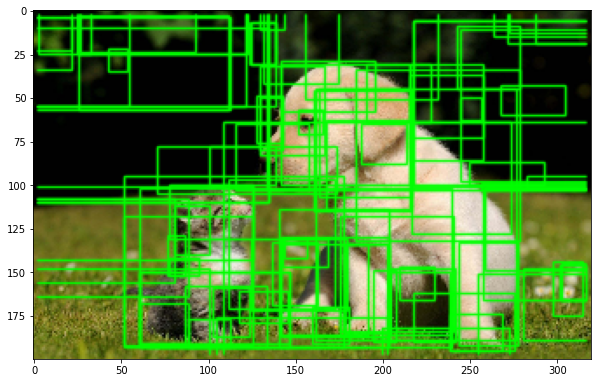

In [6]:
# selective search using OpenCV

import cv2
import matplotlib.pyplot as plt


# speed-up using multithreads
cv2.setUseOptimized(True)
cv2.setNumThreads(4)

# read image
im = cv2.imread('sample_image.jpg')


# resize image
newHeight = 200
newWidth = int(im.shape[1] * 200 / im.shape[0])
im = cv2.resize(im, (newWidth, newHeight))

# create Selective Search Segmentation Object using default parameters
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()


# set input image on which we will run segmentation
ss.setBaseImage(im)

# Switch to fast but low recall Selective Search method
ss.switchToSelectiveSearchFast()

# Switch to high recall but slow Selective Search method
# ss.switchToSelectiveSearchQuality()

# run selective search segmentation on input image
rects = ss.process()
print(f'Total Number of Region Proposals: {len(rects)}')

# number of region proposals to show
numShowRects = 100

imOut = im.copy()
for i, rect in enumerate(rects):
    # draw rectangle for region proposal till numShowRects
    if (i < numShowRects):
        x, y, w, h = rect
        cv2.rectangle(
            imOut, (x, y), (x + w, y + h),
            (0, 255, 0), 1, cv2.LINE_AA
        )
    else:
        break

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(imOut, cv2.COLOR_BGR2RGB))
plt.show()

The Region Proposal network also introduced a novel concept called **Anchor boxes** which has become a gold standard there after in building object detection pipelines. Lets deep dive and see how various stages of the pipelines works together in Faster R-CNN.
The usual data flow in Faster R-CNN when training the network is as written below
1. Features Extraction from the image.
2. Creating anchor targets.
3. Locations and objectness score prediction from the RPN network.
4. Taking the top N locations and their objectness scores aka proposal layer
5. Passing these top N locations through Fast R-CNN network and generating locations and cls predictions for each location is suggested in 4.
6. Generating proposal targets for each location suggested in 4
7. Using 2 and 3 to calculate rpn_cls_loss and rpn_reg_loss.
8. using 5 and 6 to calculate roi_cls_loss and roi_reg_loss.



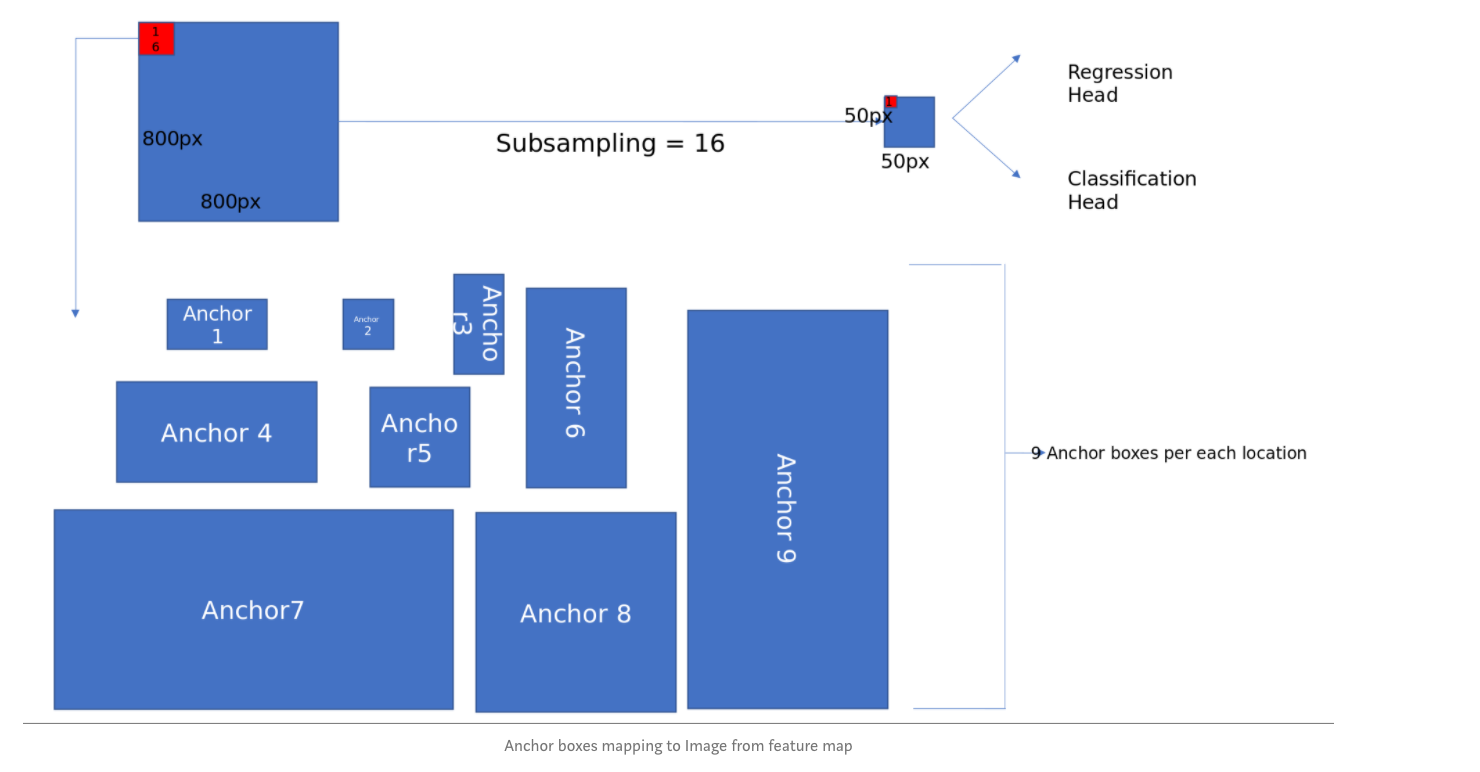

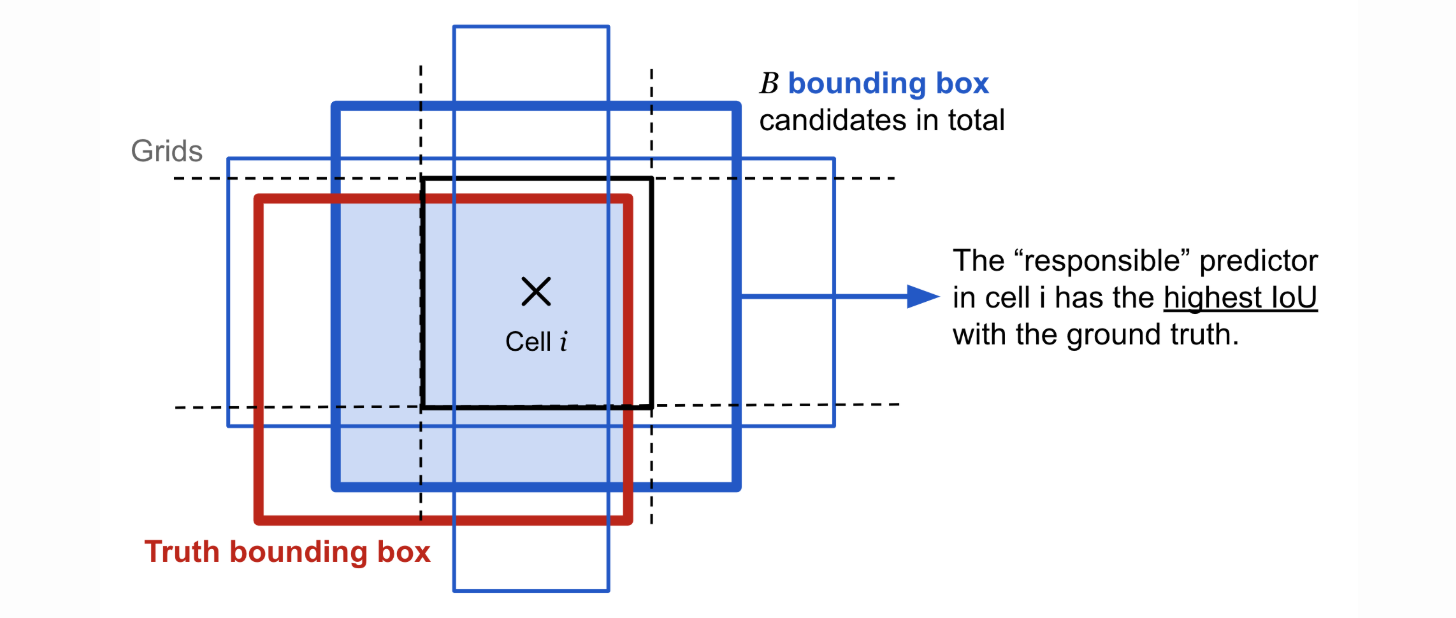

For more details please see:

* https://medium.com/@fractaldle/brief-overview-on-object-detection-algorithms-ec516929be93
* https://medium.com/@fractaldle/guide-to-build-faster-rcnn-in-pytorch-95b10c273439
* https://www.geeksforgeeks.org/selective-search-for-object-detection-r-cnn/

<font color='purple'>**FPN is not an object detector by itself. It is a feature extractor that works with object detectors.**</font>

## [Feature Pyramid Networks for Object Detection](https://arxiv.org/pdf/1612.03144.pdf)

Tsung-Yi Lin, Piotr Dollar, Ross Girshick, Kaiming He, Bharath Hariharan, Serge Belongie

### Introduction

[Paper](https://arxiv.org/pdf/1612.03144.pdf) (by Facebook AI Research (FAIR), Cornell University and Cornell Tech) was published at 2017 and its suggests an approch to create **pyramidal hierarchy of deep convolutional networks to construct feature pyramids with marginal extra cost**. 


Detecting objects in different scales is challenging in particular for small objects. We can use a pyramid of the same image at different scale to detect objects. These pyramids are scale-invariant in the sense that an object’s scale change is offset by shifting its  level in the pyramid. Intuitively, this property enables a model to detect objects across a large range of scales by scanning the model over both positions and pyramid levels.

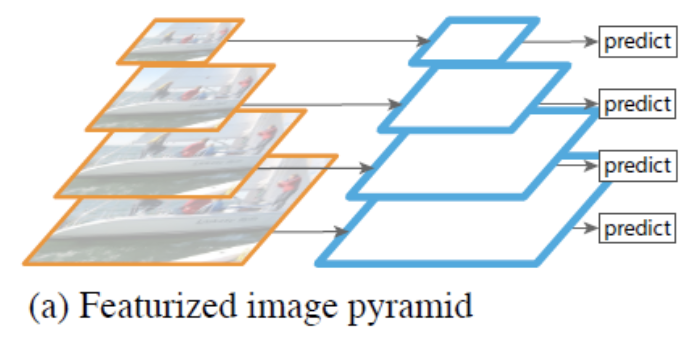

With the development of **ConvNets** the hand-engineered features have largely been replaced with features computed by deep convolutional networks. Aside from being
capable of representing higher-level semantics, ConvNets are also more robust to variance in scale and thus facilitate recognition from features computed on a single input scale:

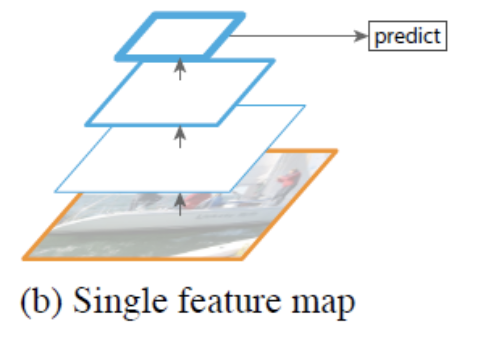


But even with this robustness, pyramids are still needed to get the most accurate results. All recent top entries in the ImageNet and COCO detection challenges use multi-scale testing on featurized image pyramids. ***The principle advantage of featurizing each level of an image pyramid is that it produces a multi-scale feature representation in which all levels are semantically strong, including the high-resolution levels.***

Nevertheless, featurizing each level of an image pyramid has obvious <font color='red'>**limitations**</font>: *processing multiple scale images is time consuming and the memory demand is too high to be trained end-to-end simultaneously*. Inference time increases considerably, making this approach impractical for real applications. Moreover, training deep networks end-to-end on an image pyramid is infeasible in terms of memory.

*However, image pyramids are not the only way to compute a multi-scale feature representation.* ***A deep ConvNet computes a feature hierarchy layer by layer, and with subsampling layers the feature hierarchy has an inherent multiscale, pyramidal shape***. This in-network feature hierarchy produces feature maps of different spatial resolutions, but
introduces large semantic gaps caused by different depths. The high-resolution maps (feature maps closer to the image layer) have low-level features that harm their representational capacity for object recognition.

The [Single Shot Detector (SSD)](https://arxiv.org/abs/1512.02325) is one of the first attempts at using a ConvNet’s pyramidal feature hierarchy as if it were a featurized image pyramid. Ideally, the SSD-style pyramid would reuse the multi-scale feature maps from different layers computed in the forward pass and thus come free of cost. But to avoid using low-level features SSD foregoes reusing already computed layers and instead builds the pyramid starting from high up in the network and then by adding several new layers. Thus it misses the opportunity to reuse the higher-resolution maps of the feature hierarchy. The authors of FPN show that these are important for detecting small objects.

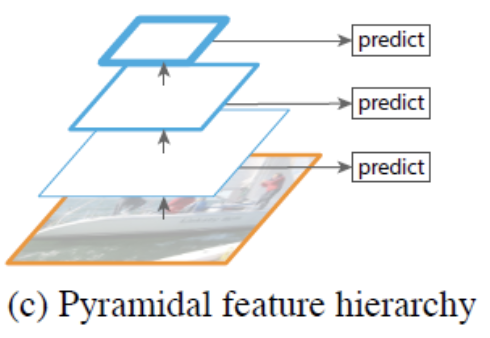

SSD architecture:
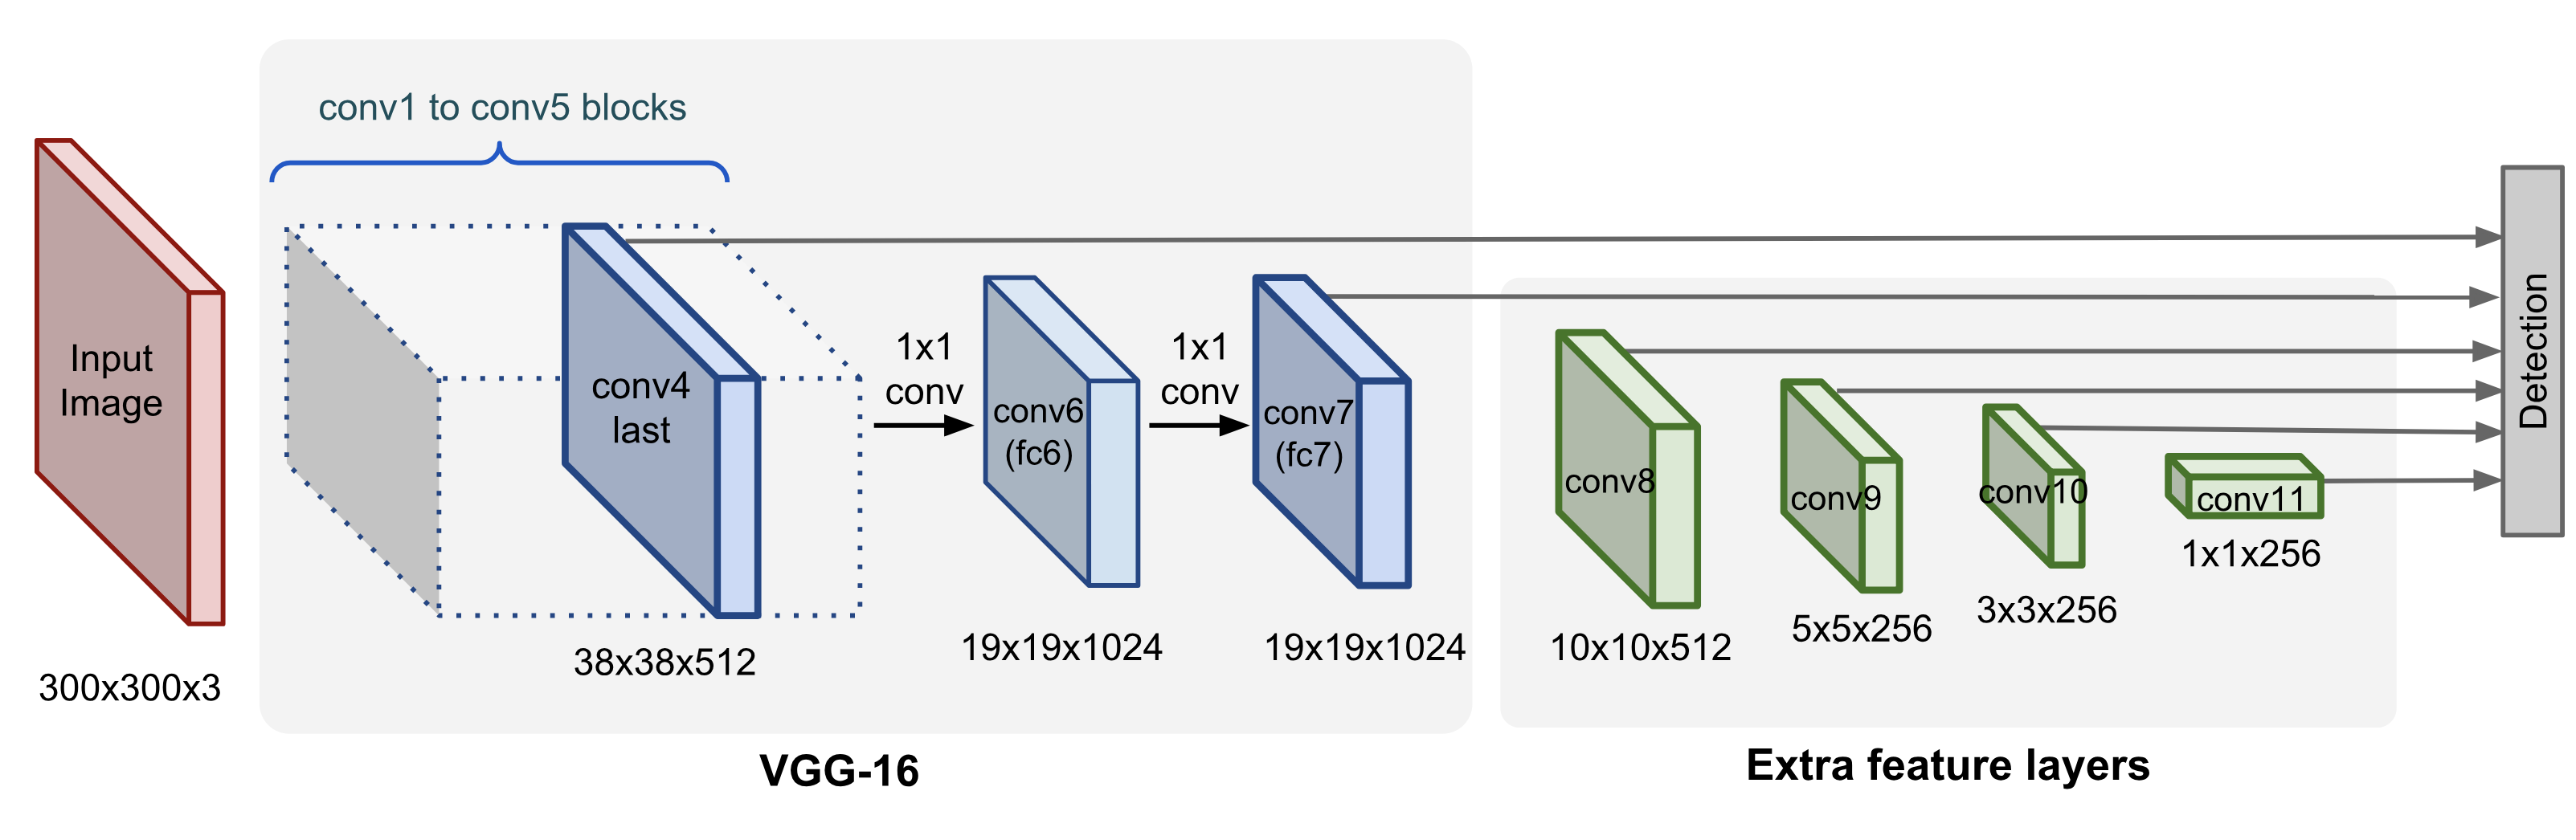

The goal of this paper is to naturally leverage the pyramidal shape of a ConvNet’s feature hierarchy while creating a feature pyramid that has strong semantics at all
scales. To achieve this goal, authors rely on an architecture that **combines low-resolution, semantically strong features with high-resolution, semantically weak features via a top-down pathway and lateral connections**. The result is a feature pyramid that has rich semantics at all levels and is built quickly from a single input image scale. In other
words, authors show how to create in-network feature pyramids that can be used to replace featurized image pyramids without sacrificing representational power, speed, or memory. 

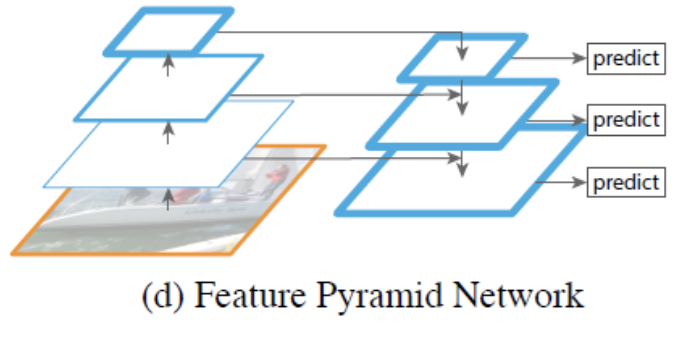

This model leverages the architecture as a feature pyramid where predictions (e.g., object detections) are independently made on each level.

### Feature Pyramid Networks

The goal of paper is to leverage a ConvNet’s pyramidal feature hierarchy, which has semantics from low to high levels, and build a feature pyramid with high-level semantics throughout. The resulting Feature Pyramid Network is general purpose and in this paper focuses on sliding window proposers (Region Proposal Network, RPN for short) and
region-based detectors (Fast R-CNN).

***This method takes a single-scale image of an arbitrary size as input, and outputs proportionally sized feature maps at multiple levels, in a fully convolutional fashion. This process is independent of the backbone convolutional architectures and in this paper presents results using [ResNets](https://arxiv.org/abs/1512.03385). The construction of our pyramid involves a bottom-up pathway, a top-down pathway, and lateral connections.***

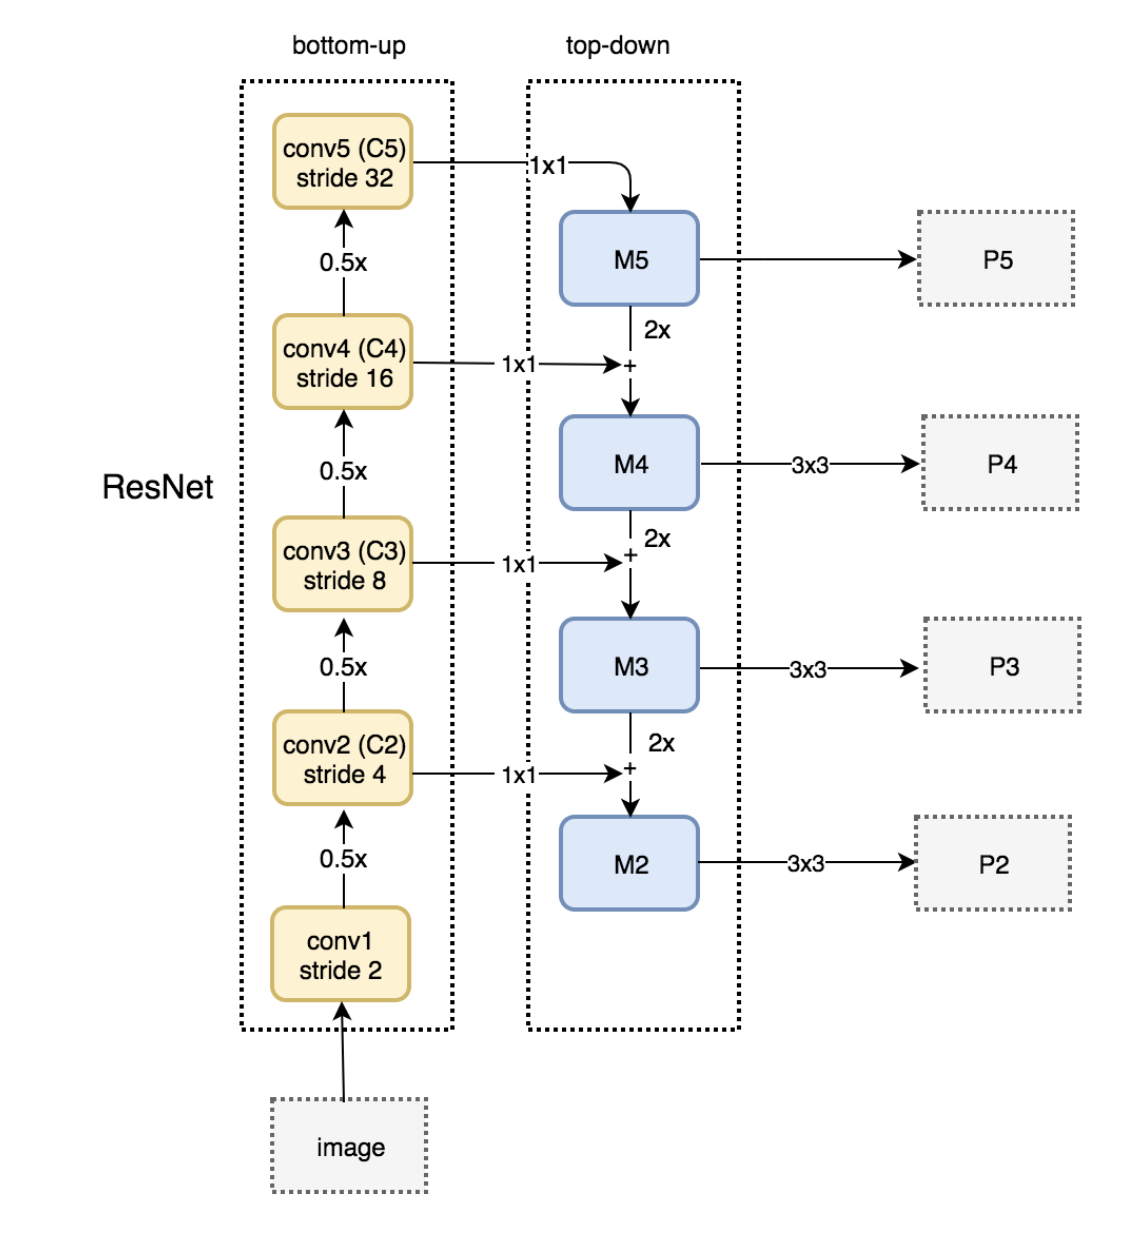

(source - https://medium.com/@jonathan_hui/understanding-feature-pyramid-networks-for-object-detection-fpn-45b227b9106c)

#### a) bottom-up pathway

The bottom-up pathway is the usual convolutional network for feature extraction which computes a feature hierarchy consisting of feature maps at several scales with a scaling step of 2. As we go up, the **spatial resolution decreases**. With more high-level structures detected, the **semantic value** for each layer **increases**.

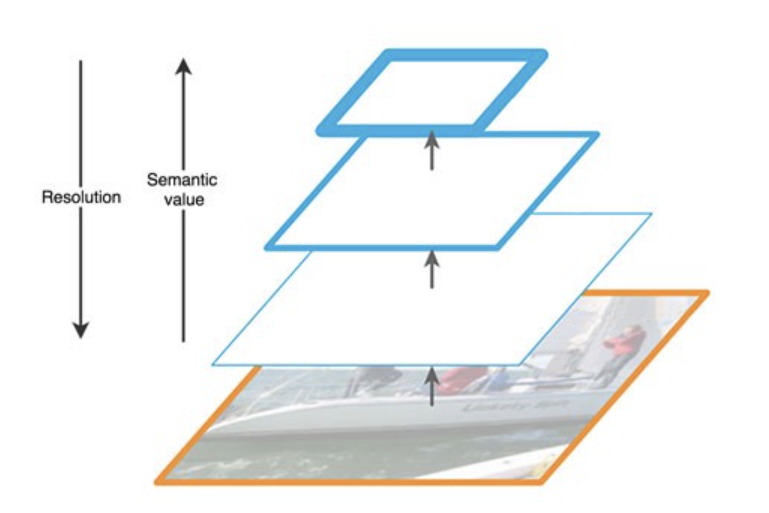

Specifically, for ResNets we use the feature activations output by each stage’s last residual block. We denote the output of these last residual blocks as `{C2, C3, C4, C5}` for conv2, conv3, conv4, and conv5 outputs, and note that they have strides of `{4, 8, 16, 32}` pixels with respect to the input image. conv1 is not included into the pyramid due
to its large memory footprint.

#### b) top-down pathway and lateral connections

FPN provides a top-down pathway to construct higher resolution layers from a semantic rich layer. While the reconstructed layers are semantic strong but the locations of objects are not precise after all the downsampling and upsampling. We add lateral connections between reconstructed layers and the corresponding feature maps to help the detector to predict the location betters. It also acts as skip connections to make training easier (similar to what ResNet does).

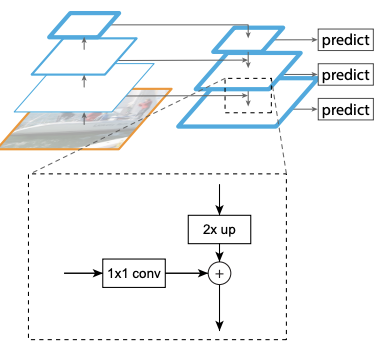

With a coarser-resolution feature map, we upsample the spatial resolution by a factor of 2 (using nearest neighbor upsampling for simplicity). The upsampled map is then merged with the corresponding bottom-up map (which undergoes a 1×1 convolutional layer to reduce channel dimensions) by element-wise addition. This process is iterated until the finest resolution map is generated.

To start the iteration, we simply attach a 1×1 convolutional layer on C5 to produce reduce C5 channel depth to 256-d to create M5. This becomes the first feature map layer used for object prediction. Finally, we append a 3×3 convolution on each merged map to generate the final feature map, which is to reduce the aliasing effect of upsampling. This final set of feature maps is called `{P2, P3, P4, P5}`, corresponding to `{C2, C3, C4, C5}` that are respectively of the same spatial sizes.

Because all levels of the pyramid use shared classifiers/regressors as in a traditional featurized image pyramid, we fix the feature dimension (numbers of channels, denoted
as d) in all the feature maps. We set d = 256 in this paper and thus all extra convolutional layers have 256-channel outputs. There are no non-linearities in these extra layers,
which we have empirically found to have minor impacts.

### Applications

#### a) FPN for RPN (Region Proposal Network)

[RPN](https://arxiv.org/abs/1506.01497) is a sliding-window class-agnostic object detector. In the original RPN design, a small subnetwork is evaluated on dense 3×3 sliding windows, on top of a **single scale convolutional feature map**, performing object/nonobject binary classification and bounding box regression.
This is realized by a 3×3 convolutional layer followed by two sibling 1×1 convolutions for classification and regression, which we refer to as a network head. The object/nonobject criterion and bounding box regression target are defined with respect to a set of reference boxes called anchors. The anchors are of multiple pre-defined scales and
aspect ratios in order to cover objects of different shapes. 

**Authors adapt RPN by replacing the single-scale feature map with FPN**. In the FPN framework, for each scale level (say P4), a 3 × 3 convolution filter is applied over the feature maps followed by separate 1 × 1 convolution for objectness predictions and boundary box regression. These 3 × 3 and 1 × 1 convolutional layers are called the RPN head. The same head is applied to all different scale levels of feature maps. Because the head slides densely over all locations in all pyramid levels, it is not necessary to have multi-scale anchors on a specific level. Instead, we assign anchors of a single scale to each level. Formally, we define the anchors to have areas of $\{32^2, 64^2, 128^2, 256^2, 512^2\}$ pixels on {P2, P3, P4, P5, P6} respectively. As in original paper of Faster R-CNN we also
use anchors of multiple aspect ratios {1:2, 1:1, 2:1} at each level. So in total there are 15 anchors over the pyramid.

We assign training labels to the anchors based on their Intersection-over-Union (IoU) ratios with ground-truth
bounding boxes as in Faster R-CNN. Formally, an anchor is assigned a positive label if it has the highest IoU for a given groundtruth box or an IoU over 0.7 with any ground-truth box, and a negative label if it has IoU lower than 0.3 for all ground-truth boxes. 

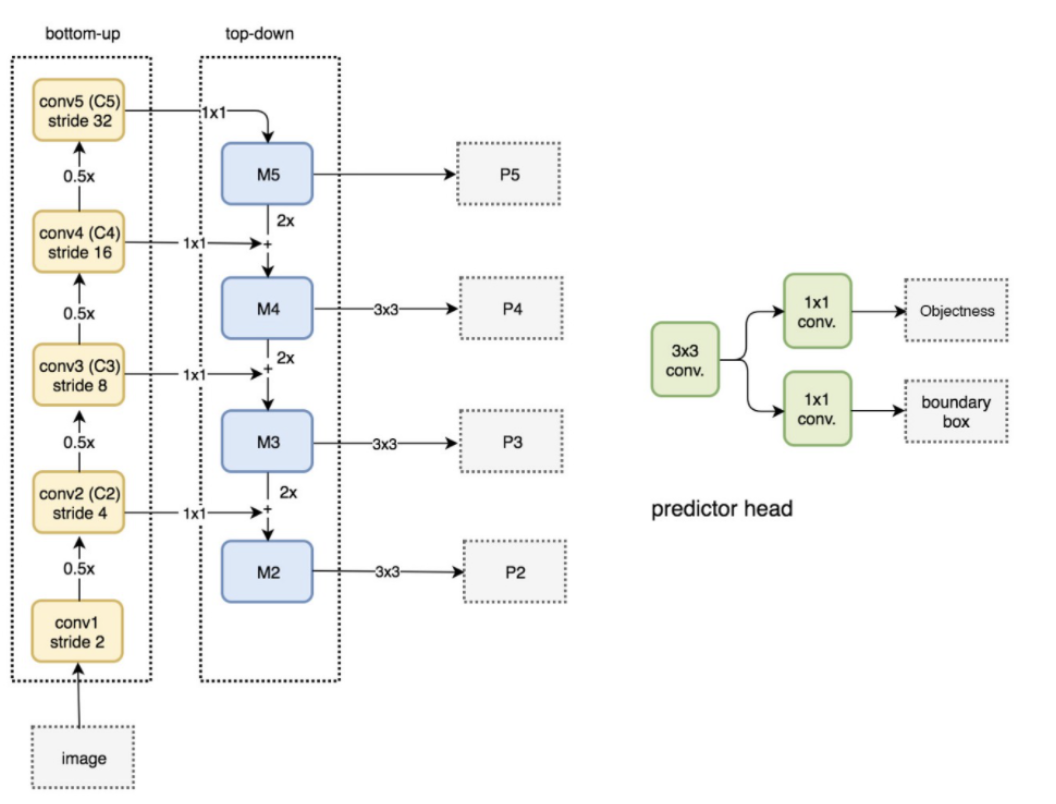

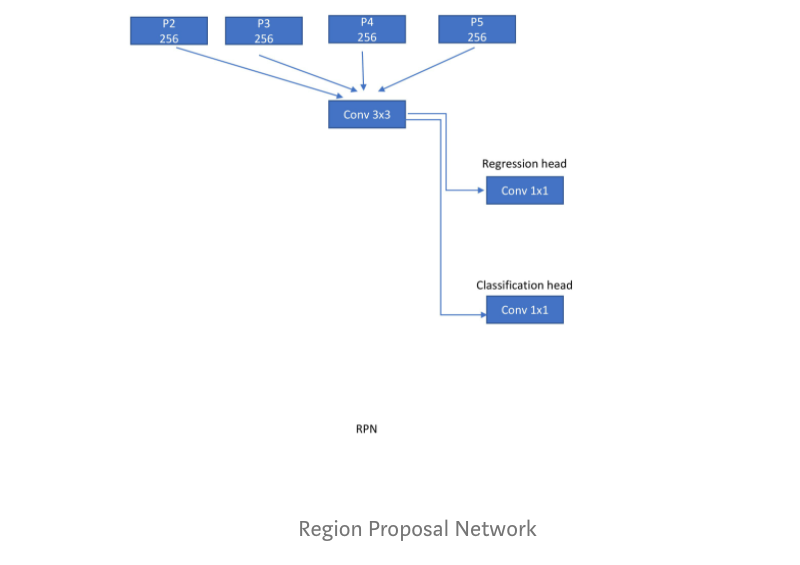

Detailed explaination about RPN can be found:

* https://arxiv.org/pdf/1506.01497.pdf
* https://tryolabs.com/blog/2018/01/18/faster-r-cnn-down-the-rabbit-hole-of-modern-object-detection/
* https://www.quora.com/How-does-the-region-proposal-network-RPN-in-Faster-R-CNN-work


#### b) FPN with Fast R-CNN or Faster R-CNN

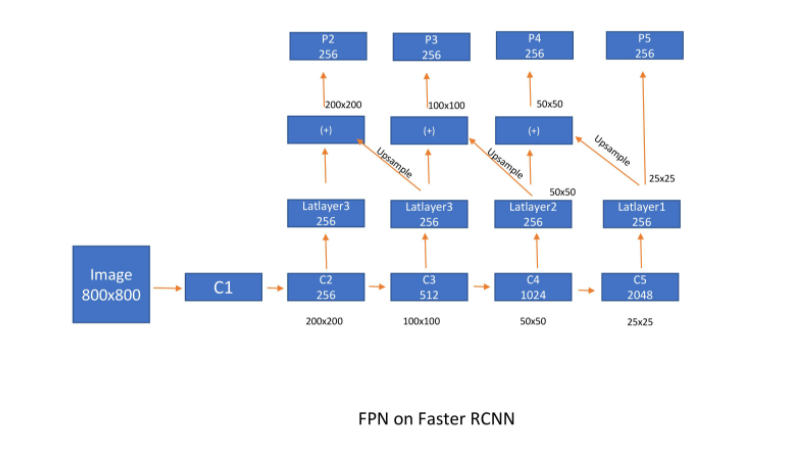

Fast R-CNN is a region-based object detector in which Region-of-Interest (RoI) pooling is used to extract features. Fast R-CNN is most commonly performed on a
single-scale feature map. To use it with our FPN, we need to assign RoIs of different scales to the pyramid levels.

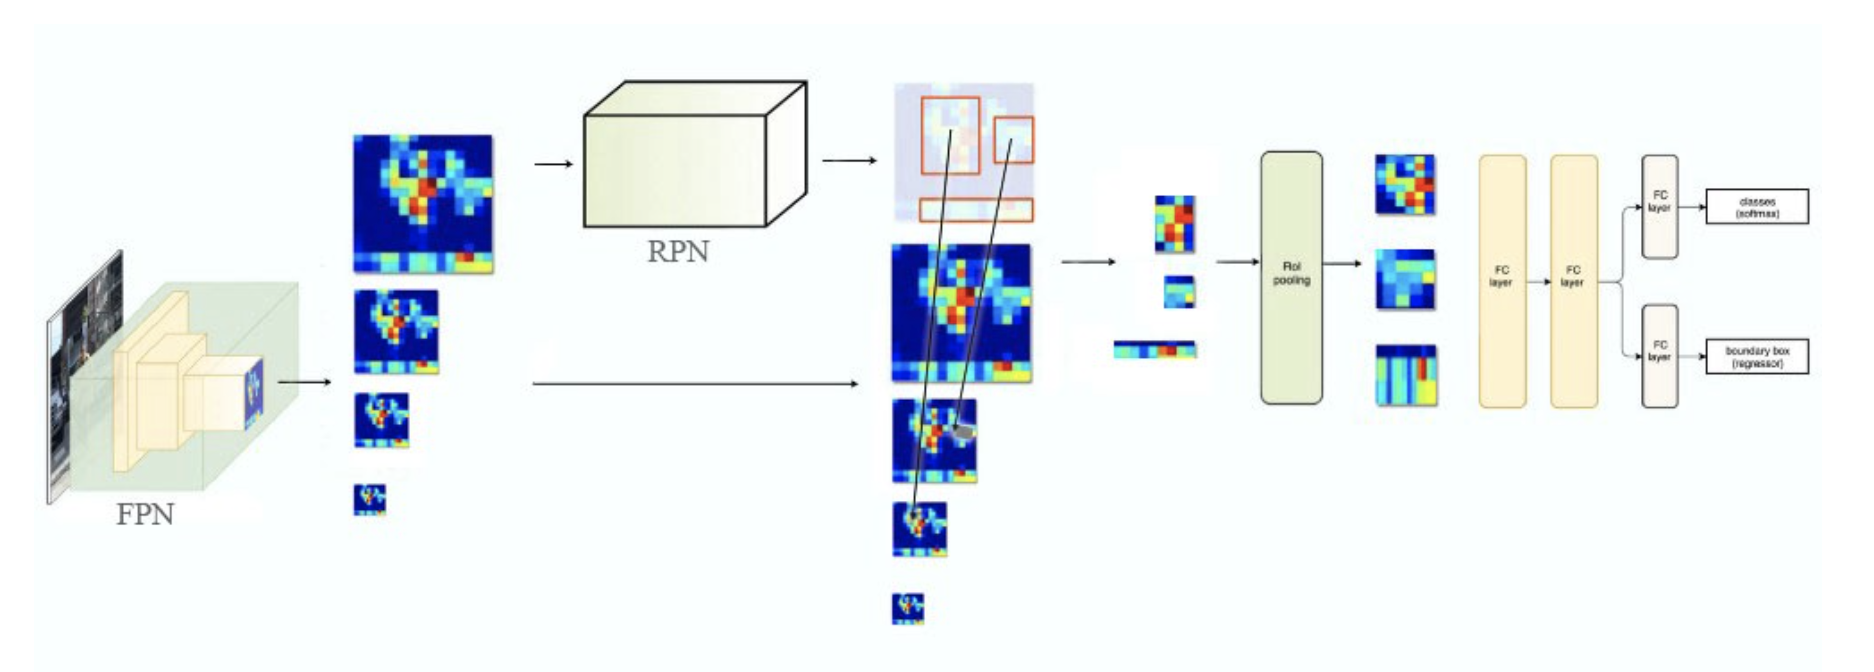

Formally, we assign an RoI of width w and height h (on the input image to the network) to the level $P_{k}$ of our feature pyramid by: 

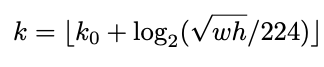

Here 224 is the canonical ImageNet pre-training size, and $k_{0}=4$ is the target level on which an RoI with $w × h = 224^2$ should be mapped into. Intuitively, formula means
that if the RoI’s scale becomes smaller (say, 1/2 of 224), it should be mapped into a finer-resolution level (say, k = 3).